#1. alpha와 beta
- 개별 주식이나 포트폴리오의 위험을 나타내는 상대적인 지표
- 시장 리스크 등 기준이 되는 지표와의 상대적 변동성의 비율
- CAPM(자본자산가격결정모형)에서 개별자산과 포트폴리오의 위험을 측정

 - Alpha: 주식 투자의 초과 수익률, 기대 수익률과 기준 지수의 예상 수익률 간 차이. alpha>0: 시장 평균보다 초과 수익
 - Beta: 주식 또는 포트폴리오의 변동성이 시장 변동성과 연관 정도 측정. beta가 1에 가까우면 시장과의 상관관계가 높고, 1보다 작으면 시장보다 변동성이 낮으며, 1보다 크면 시장보다 변동성이 높음

In [4]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

In [5]:
risky_asset = 'AMZN'
market_benchmark = '^GSPC'  #S&P500
start_date = '2022-01-01'
end_date = '2023-12-31'

In [6]:
df = yf.download( [risky_asset, market_benchmark], start=start_date, end = end_date, progress=False)

/tmp/ipython-input-66951337.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download( [risky_asset, market_benchmark], start=start_date, end = end_date, progress=False)


In [7]:
X = df['Close'].rename(columns={risky_asset: 'asset', market_benchmark: 'market'}).resample('M').last().pct_change().dropna()
X

/tmp/ipython-input-4166839863.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  X = df['Close'].rename(columns={risky_asset: 'asset', market_benchmark: 'market'}).resample('M').last().pct_change().dropna()


Ticker,asset,market
Date,,
2022-02-28,0.026673,-0.031360
2022-03-31,0.061437,0.035773
2022-04-30,-0.237525,-0.087957
2022-05-31,-0.032764,0.000053
2022-06-30,-0.116459,-0.083920
2022-07-31,0.270596,0.091116
2022-08-31,-0.060615,-0.042440
2022-09-30,-0.108622,-0.093396
2022-10-31,-0.093451,0.079863


In [8]:
covariance = X.cov().iloc[0,1]
benchmark_variance = X['market'].var()
beta = covariance / benchmark_variance
beta

np.float64(1.4487845995278597)

In [9]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X[['market']], X['asset'])
model.coef_[0]

np.float64(1.4487845995278594)

#2. 포트폴리오
* 포트폴리오 최적화: 투자자 목표 수익율과 위험 선호도에 따라 가장 적합한 자산 배분 탐색

* 포트폴리오란? 투자자가 보유한 주식과 채권 등 여러 투자자산으로 이루어진 그룹

* 현대 포트폴리오 이론(Modern Portfolio Theory)
 - 해리 마코위츠, 상관관계가 낮은 여러 자산을 섞어서 분산투자
 - 동일한 수익율에서 위험을 낮출 수 있음
 - 위험은 낮추고 기대 수익율은 높은 포트폴리오 추구
 - High Risk High Return을 극복
 - 위험 대비 기대수익율이 높은 조합을 발견
 - 분산 투자의 중요성

* 포트폴리오의 체계적, 비체계적 위험
 - 시장위험 = 체계적 위험
 - 개별 자산 위험 = 비체계적 위험
 - 잘 분산된 PF는 비체계적 위험이 0에 가깝게 설정하여 최소화

* 라이브러리: PyPortfolioOpt

In [10]:
!pip install PyPortfolioOpt

In [11]:
import yfinance as yf
ticker_names = {
    '^KS11': 'KOSPI',
    '^KQ11': 'KOSDAQ',
    '348210.KQ': '넥스틴',
    '058610.KQ': '에스피지',
    '114840.KQ': '아이패밀리에스씨',
    '007660.KS': '이수페타시스',
    '272210.KS': '한화시스템',
    '093320.KQ': '케이아이엔엑스',
    '003230.KS': '삼양식품',
    '024110.KS': '기업은행',
    '347890.KQ': '엠투아이',
    '119610.KQ': '인터로조',
    '215000.KQ': '골프존',
    '336260.KS': '두산퓨얼셀',
    '005300.KS': '롯데칠성',
    '281740.KQ': '레이크머티리얼즈',
    '253450.KQ': '스튜디오드래곤',
    '213420.KQ': '덕산네오룩스',
    '006890.KS': '태경케미컬',
    '060720.KQ': 'KH바텍',
    '190510.KQ': '나무가',
    '002310.KS': '아세아제지',
    '013310.KQ': '아진산업',
    '003720.KS': '삼영',
    '025320.KQ': '시노펙스',
    '383310.KQ': '에코프로에이치엔',
    '145720.KS': '덴티움',
    '337930.KQ': '브랜드엑스코퍼레이션',
    '393890.KQ': '더블유씨피',
    '074600.KQ': '원익QnC',
    '251970.KQ': '펌텍코리아',
    '166090.KQ': '하나머티리얼즈',
    '036890.KQ': '진성티이씨',
    '089850.KQ': '유비벨록스',
    '403870.KQ': 'HPSP',
    '104540.KQ': '코렌텍',
    '047810.KS': '한국항공우주',
    '183300.KQ': '코미코',
    '298050.KS': '효성첨단소재',
    '214150.KQ': '클래시스',
    '086670.KQ': '비엠티',
    '078350.KQ': '한양디지텍',
    '307950.KS': '현대오토에버',
    '332370.KQ': '아이디피',
    '192820.KS': '코스맥스',
    '259960.KS': '크래프톤',
}
tickers = list(ticker_names.keys())

In [54]:
df = yf.download(tickers)
prices = df["Close"].dropna(how="all")
prices.rename(columns=ticker_names, inplace=True)

/tmp/ipython-input-1445602210.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers)
[*********************100%***********************]  46 of 46 completed


#3. 자본자산 가격결정(CAPM: Capital Asset Pricing Model)
 - 개별 종목의 기대수익율: 시장 전체 수익율의 흐름에 영향
 - 위험 자산 기대 수익율 = 무위험자산 수익율 + b X Risk Premium
 - Risk Premium: 시장 수익율 = 무위험자산 수익율
 - beta: 위험자산 민감도, 특정 자산의 체계적 위험 측정 지표
 - beta = 시장 수익율과 위험자산 수익율의 공분산 /  위험자산 수익율의 분산
 - ols로 추정
 - 개별 종목 기대수익율은 개별 종목 위험에 비례
 - 베타: 개별 종목의 기대수익율 추정

In [ ]:
!unzip malgun.zip

In [14]:
import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리

fe = fm.FontEntry(fname=r'malgun.ttf', name='malgun') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'malgun'}) #폰트설정

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 [Text(0, 0, '아세아제지'),
  Text(1, 0, '삼양식품'),
  Text(2, 0, '삼영'),
  Text(3, 0, '롯데칠성'),
  Text(4, 0, '태경케미컬'),
  Text(5, 0, '이수페타시스'),
  Text(6, 0, '아진산업'),
  Text(7, 0, '기업은행'),
  Text(8, 0, '시노펙스'),
  Text(9, 0, '진성티이씨'),
  Text(10, 0, '한국항공우주'),
  Text(11, 0, '에스피지'),
  Text(12, 0, 'KH바텍'),
  Text(13, 0, '원익QnC'),
  Text(14, 0, '한양디지텍'),
  Text(15, 0, '비엠티'),
  Text(16, 0, '유비벨록스'),
  Text(17, 0, '케이아이엔엑스'),
  Text(18, 0, '코렌텍'),
  Text(19, 0, '아이패밀리에스씨'),
  Text(20, 0, '인터로조'),
  Text(21, 0, '덴티움'),
  Text(22, 0, '하나머티리얼즈'),
  Text(23, 0, '코미코'),
  Text(24, 0, '나무가'),
  Text(25, 0, '코스맥스'),
  Text(26, 0, '덕산네오룩스'),
  Text(27, 0, '클래시스'),
  Text(28, 0, '골프존'),
  Text(29, 0, '펌텍코리아'),
  Text(30, 0, '스튜디오드래곤'),
  Text(31, 0, '크래프톤'),
  Text(32, 0, '한화시스템'),
  Text(33, 0, '레이크머티리얼즈'),
  T

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  func(*args, **kwargs)


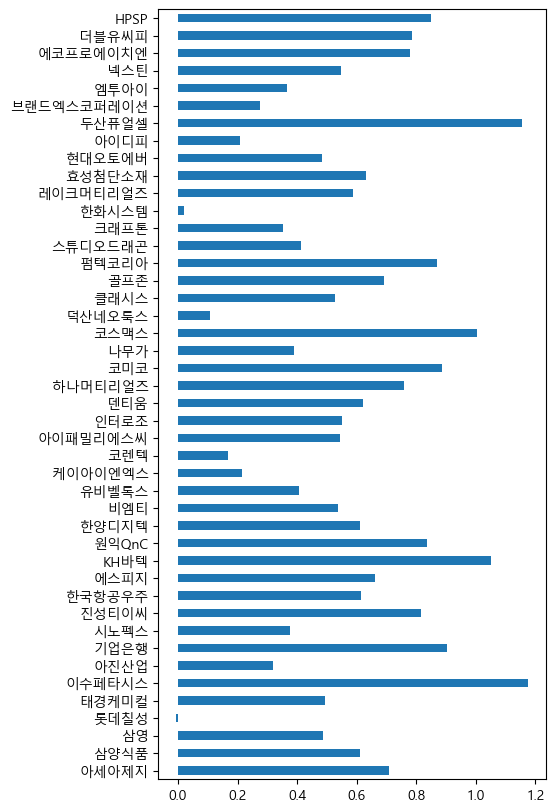

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


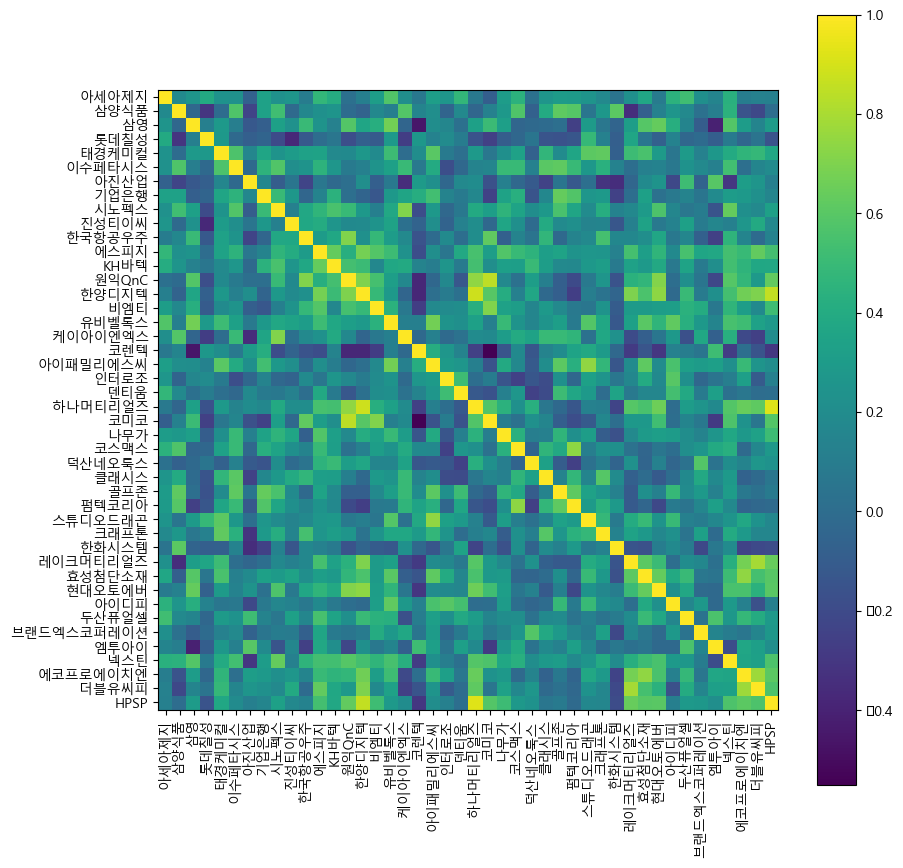

In [58]:
from pypfopt import expected_returns

prices_ind = prices.drop(["KOSPI", "KOSDAQ"],axis=1)

risk_free_rate= 0.028	#한국무위험지표금리의 1년 평균 사용, 3.5%
mu = expected_returns.capm_return(prices_ind, market_prices=prices['KOSPI'].to_frame(), risk_free_rate=risk_free_rate, frequency=252)	#1년 지정
mu.plot.barh(figsize=(5, 10))

#각 자산간 상관관계
import matplotlib.pyplot as plt
import numpy as np
from pypfopt import risk_models
from pypfopt import plotting

S = risk_models.sample_cov(prices_ind, frequency=252)

# Plot the correlation matrix
matrix = risk_models.cov_to_corr(S)
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(matrix)
fig.colorbar(cax)
ax.set_xticks(np.arange(0, matrix.shape[0], 1))
ax.set_xticklabels(matrix.index)
ax.set_yticks(np.arange(0, matrix.shape[0], 1))
ax.set_yticklabels(matrix.index)
plt.xticks(rotation=90)

#4. Efficient Frontier
- 투자 대상 중 가장 적절한 수익율과 위험을 가진 종목을 이은 곡선
- 효율적 포트폴리오: 주어진 위험 수준 대비 가장 높은 수익률을 제공하는 포트폴리오
- MPT에서의 위험: 수익률의 변동성( 과거 수익률의 표준편차)
- 동일한 기대 수익률 내에서 가장 작은 위험을 가진 포트폴리오의 집합
- 개별 종목의 기대수익률은 개별 종목의 위험에 비례하며 커지며, 특히 기대수익률 대비 위험이 큰 종목도 있고 낮은 종목도 있음
- 효율적 프론티어란 동일한 위험에서 가장 높은 수익률을 기대할 수 있는 종목들을 선으로 이은 것


In [59]:
import matplotlib.pyplot as plt
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)

for name in list(ticker_names.values()):
    if name != 'KOSPI' and name != 'KOSDAQ':
        ef.add_constraint(lambda w: w[ef.tickers.index(name)] <= 0.1) # 개별종목 비중 10% 안 넘게


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Expected annual return: 60.8%
Annual volatility: 16.6%
Sharpe Ratio: 3.49


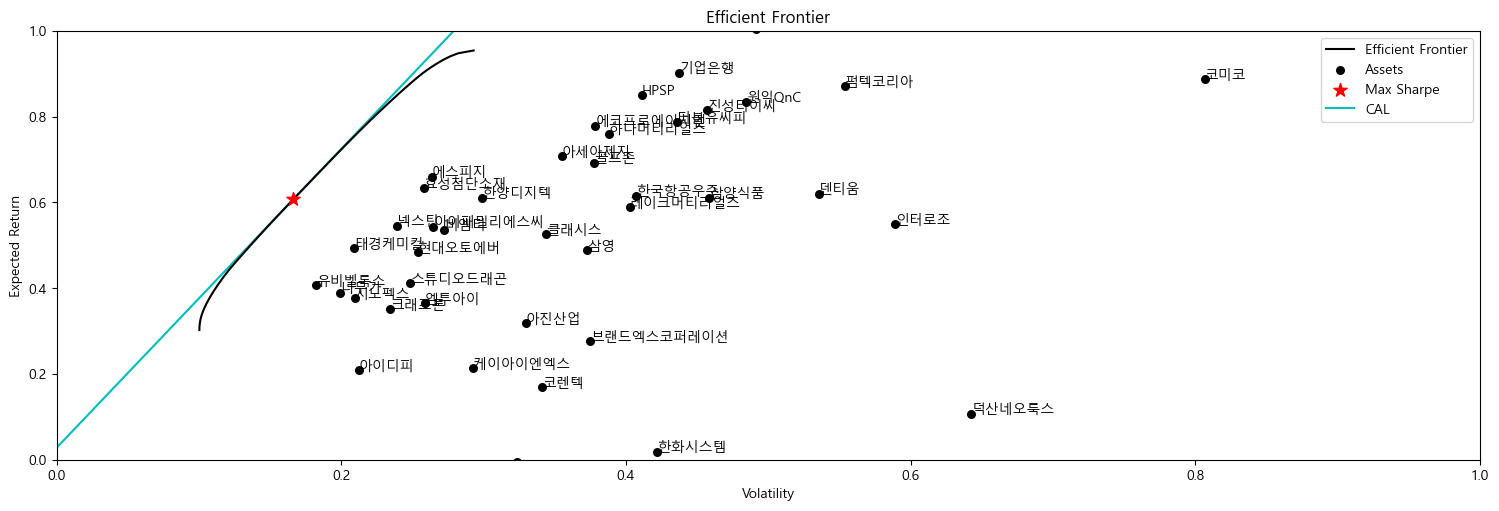

In [60]:
# Plot efficient frontier
fig, ax = plt.subplots(figsize=(15, 5))

plotting.plot_efficient_frontier(ef.deepcopy(), ax=ax, show_tickers=True)
ax.get_lines()[0].set_color("black")

# Plot the tangency portfolio
ef.max_sharpe(risk_free_rate)
weights = ef.clean_weights()
ret_tangent, std_tangent, _ = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)
ax.scatter(std_tangent, ret_tangent, s=100, c="r", marker="*", label="Max Sharpe", zorder=10)

# Plot capital allocation line
ax.plot([0, std_tangent, std_tangent*2], [risk_free_rate, ret_tangent, 2*ret_tangent-risk_free_rate], 'c', label='CAL', zorder=-1)

# Format
ax.set_title("Efficient Frontier")
ax.set_ylabel('Expected Return')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
handles, labels = ax.get_legend_handles_labels()
labels[0], labels[1] = ['Efficient Frontier', 'Assets']
ax.legend(handles, labels)
plt.show()


 - 포트폴리오에서는 단일 종목의 비중이 너무 크지 않도록 제한: 예, 10%
 - 효율적 프론티어 우측은 상대적으로 위험이 크고 기대 수익률은 낮음

<Axes: xlabel='Weight'>

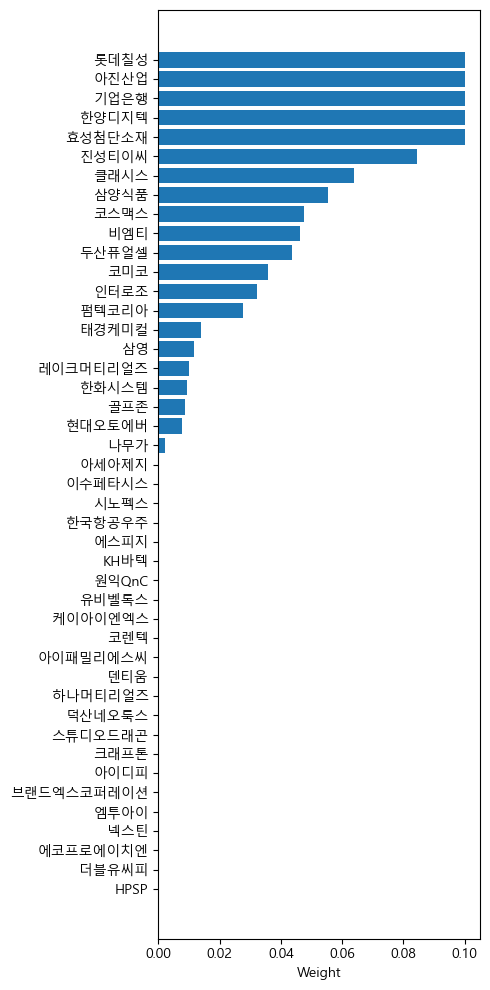

In [61]:
fig, ax = plt.subplots(figsize=(5, 10))
plotting.plot_weights(weights, ax=ax)

- CAL: 효율적 프론티어 곡선에 접하는 직선,자본배분선
- MPT에서 도출된 위험자산만으로 구성된 효율적 포트폴리오에 무위험자산을 포함, 낮은 위험과 높은 기대수익률의 포트폴리오 집합, 이를 자본배분선으로 지칭

- 자본배분선의 y 절편: 무위험자산을 100% 보유하는 포트폴리오, 기대 수익률은 무위험수익률과 동일
- 자본배분선과 효율적 프론티어 곡선이 접하는 지점: 위험자산만을 보유했을 때 가장 효율적인 포트폴리오
 - 자본배분선과 효율적 프론티어 곡선이 접하는 지점이 샤프 비율이 최대가 되는 포트폴리오

- 샤프 비율(Sharpe Ratio): 해리 마코위츠의 제자 윌리엄 샤프가 개발한 투자 성과 판단용 지표
 - 총위험(total risk)에 집중하는 위험 대 보상 비율(Reward-to-risk Ratio)

    Sharpe = (Rp-Rf) / Sigmap

 - 높은 샤프 비율을 기록하는 투자일수록 더 적은 위험으로 더 높은 수익률을 내고자 함
 - 샤프 비율이 0 이하라면 시장수익률보다 낮은 수익률 의미: 샤프 비율이 0 이상이어야 투자의 고려 대상, 1 이상이면 상당히 괜찮은 투자처

#5. 효율적 시장 가설(EMH; Efficient Market Hypothesis)
- 효율적 시장 가설: 가격은 상품에 대해 얻을 수 있는 모든 정보를 빠르게 반영, 투자자는 장기적으로 시장 수익률을 넘을 수 없음

- 예를 들어, 개별주와 시장 지수(Market Index)를 포함하는 포트폴리오를 최적화, 코스피가 효율적 프론티어 위에 위치하며, 포트폴리오에 코스피를 98% 이상 배분 하라는 결과

- 해석: 코스피 100%를 보유하는 것도 매우 효율적인 포트폴리오일 수 있고, 2%의 개별주를 넣으라는 것은 오히려 단기적인 오차로 인한 결과로 의심

- 한국의 주식 시장은 효율적 시장 가설을 잘 따라가는 것으로 고려, 코스피가 효율적인 포트폴리오

#6. 포트폴리오 실습

In [62]:
import yfinance as yf
ticker_names = {
    '^KS11': 'KOSPI',
    '272210.KS': '한화시스템',
    '079550.KS': 'LIG넥스원',
    '012450.KS': '한화에어로스페이스',
    '329180.KS': 'HD현대중공업',
    '042660.KS': '한화오션',
    '064350.KS': '현대로템',
    '103140.KS': '풍산',
    '047810.KS': '한국항공우주',
    '039130.KS': '하나투어',
    '004170.KS': '신세계',
    '008770.KS': '호텔신라',
    '023530.KS': '롯데쇼핑',
    '069960.KS': '현대백화점',
    '005930.KS': '삼성전자',
    '017670.KS': 'SK텔레콤',
    '030200.KS': 'KT',
    '000660.KS': 'SK하이닉스',
}
tickers = list(ticker_names.keys())

In [63]:
df = yf.download(tickers, start="2020-01-01", end="2023-12-31")
prices = df["Close"].dropna(how="all")
prices.rename(columns=ticker_names, inplace=True)

/tmp/ipython-input-79979127.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start="2020-01-01", end="2023-12-31")
[*********************100%***********************]  18 of 18 completed


In [64]:
import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리

fe = fm.FontEntry(fname=r'malgun.ttf', name='malgun') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'malgun'}) #폰트설정

/usr/local/lib/python3.11/dist-packages/pypfopt/expected_returns.py:254: RuntimeWarning: market prices are not in a dataframe
  warnings.warn("market prices are not in a dataframe", RuntimeWarning)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'SK하이닉스'),
  Text(1, 0, '신세계'),
  Text(2, 0, '삼성전자'),
  Text(3, 0, '호텔신라'),
  Text(4, 0, '한화에어로스페이스'),
  Text(5, 0, 'SK텔레콤'),
  Text(6, 0, '롯데쇼핑'),
  Text(7, 0, 'KT'),
  Text(8, 0, '하나투어'),
  Text(9, 0, '한화오션'),
  Text(10, 0, '한국항공우주'),
  Text(11, 0, '현대로템'),
  Text(12, 0, '현대백화점'),
  Text(13, 0, 'LIG넥스원'),
  Text(14, 0, '풍산'),
  Text(15, 0, '한화시스템'),
  Text(16, 0, 'HD현대중공업')])

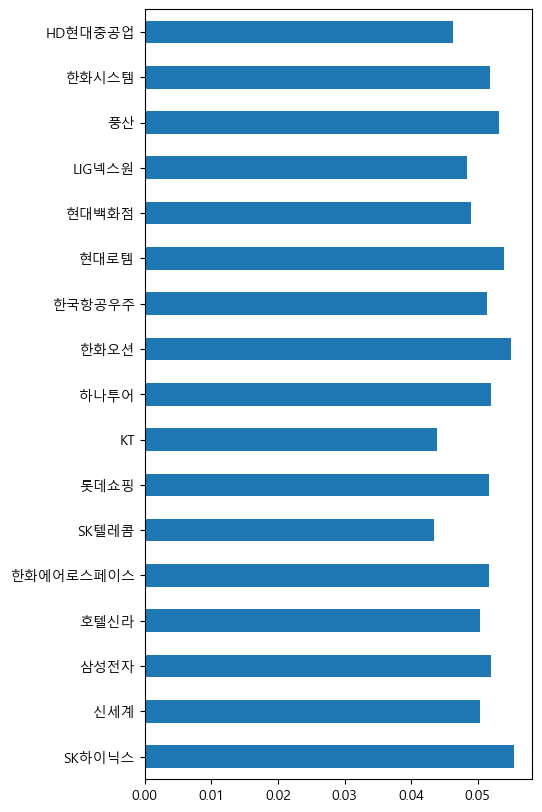

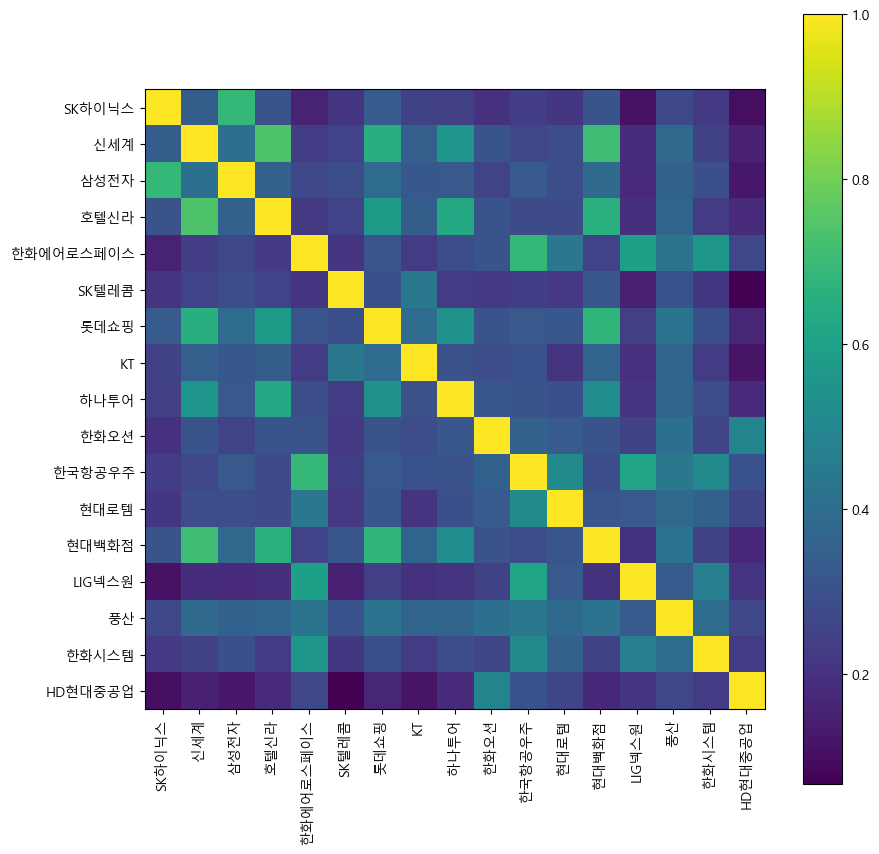

In [67]:
from pypfopt import expected_returns

risk_free_rate= 0.035	#한국무위험지표금리의 1년 평균 사용, 3.5%
mu = expected_returns.capm_return(prices.drop("KOSPI", axis=1), market_prices=prices['KOSPI'], risk_free_rate=risk_free_rate, frequency=252)	#1년 지정
mu.plot.barh(figsize=(5, 10))

#각 자산간 상관관계
import matplotlib.pyplot as plt
import numpy as np
from pypfopt import risk_models
from pypfopt import plotting

S = risk_models.sample_cov(prices.drop("KOSPI", axis=1), frequency=252)

# Plot the correlation matrix
matrix = risk_models.cov_to_corr(S)
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(matrix)
fig.colorbar(cax)
ax.set_xticks(np.arange(0, matrix.shape[0], 1))
ax.set_xticklabels(matrix.index)
ax.set_yticks(np.arange(0, matrix.shape[0], 1))
ax.set_yticklabels(matrix.index)
plt.xticks(rotation=90)

Expected annual return: 5.1%
Annual volatility: 21.0%
Sharpe Ratio: 0.08


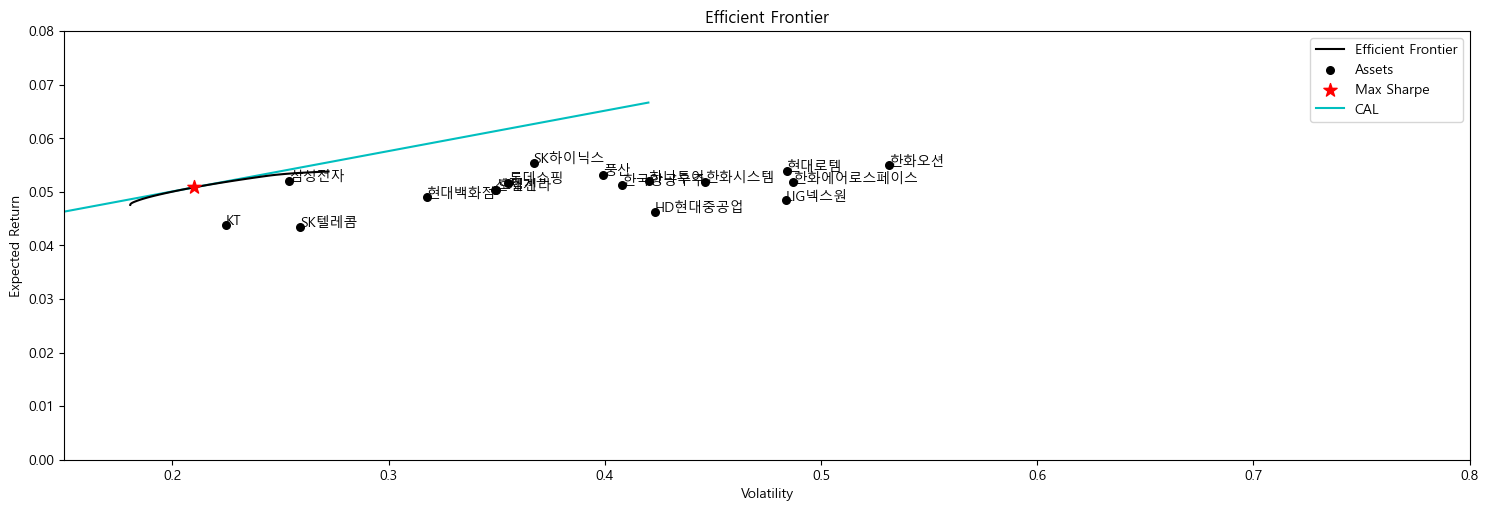

In [72]:
import matplotlib.pyplot as plt
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier

fig, ax = plt.subplots(figsize=(15, 5))
ef = EfficientFrontier(mu, S)

for name in list(ticker_names.values()):
    if name != 'KOSPI' and name != 'KOSDAQ':
        ef.add_constraint(lambda w: w[ef.tickers.index(name)] <= 0.2) # 개별종목 비중 20% 안 넘게

# Plot efficient frontier
plotting.plot_efficient_frontier(ef.deepcopy(), ax=ax, show_tickers=True)
ax.get_lines()[0].set_color("black")

# Plot the tangency portfolio
ef.max_sharpe(risk_free_rate)
weights = ef.clean_weights()
ret_tangent, std_tangent, _ = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)
ax.scatter(std_tangent, ret_tangent, s=100, c="r", marker="*", label="Max Sharpe", zorder=10)

# Plot capital allocation line
ax.plot([0, std_tangent, std_tangent*2], [risk_free_rate, ret_tangent, 2*ret_tangent-risk_free_rate], 'c', label='CAL', zorder=-1)

# Format
ax.set_title("Efficient Frontier")
ax.set_ylabel('Expected Return')
ax.set_xlim(0.15, 0.8)
ax.set_ylim(0, 0.08)
handles, labels = ax.get_legend_handles_labels()
labels[0], labels[1] = ['Efficient Frontier', 'Assets']
ax.legend(handles, labels)
plt.show()



<Axes: xlabel='Weight'>

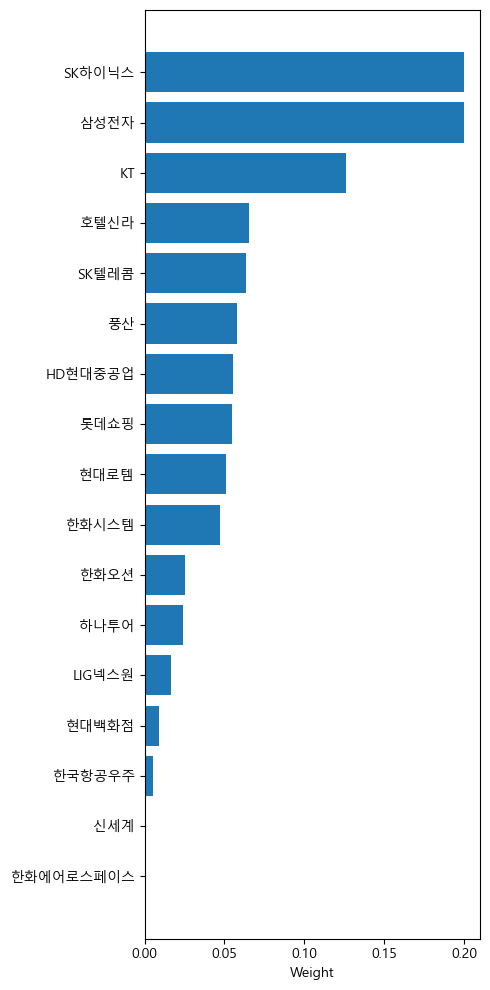

In [73]:
fig, ax = plt.subplots(figsize=(5, 10))
plotting.plot_weights(weights, ax=ax)

#7. 유망 종목 발견
- pykrx로 20250701 종목에 대한 market fundamental 데이터를 수집하여서 군집 분석하세요.
- EPS 기준 상위 20개 종목을 발견해보세요.

In [74]:
!pip install pykrx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 21.1 MB/s eta 0:00:00


In [75]:
from pykrx import stock
df = stock.get_market_fundamental("20250701")

In [76]:
df_top20 = df.nlargest(20, "EPS")

In [77]:
df_top20

,BPS,PER,PBR,EPS,DIV,DPS
티커,,,,,,
003240,4668610,4.14,0.23,254899,0.17,1750
306200,397327,3.22,0.40,48949,4.45,7000
000810,366202,9.01,1.20,48779,4.32,19000
005380,413568,4.41,0.51,47615,5.71,12000
012450,108184,18.24,7.76,46002,0.42,3500
012330,509212,6.41,0.57,44939,2.08,6000
002380,685232,7.64,0.47,42230,3.10,10000
007310,597176,9.98,0.67,40048,2.25,9000
002030,689472,8.63,0.47,37523,1.65,5330


In [78]:
ticker_name = []

for i in df_top20.index:
  ticker_name.append( stock.get_market_ticker_name(i) )

df_top20["name"] = ticker_name
df_top20["ticker"] = df_top20.index
df_top20

,BPS,PER,PBR,EPS,DIV,DPS,name,ticker
티커,,,,,,,,
003240,4668610,4.14,0.23,254899,0.17,1750,태광산업,003240
306200,397327,3.22,0.40,48949,4.45,7000,세아제강,306200
000810,366202,9.01,1.20,48779,4.32,19000,삼성화재,000810
005380,413568,4.41,0.51,47615,5.71,12000,현대차,005380
012450,108184,18.24,7.76,46002,0.42,3500,한화에어로스페이스,012450
012330,509212,6.41,0.57,44939,2.08,6000,현대모비스,012330
002380,685232,7.64,0.47,42230,3.10,10000,KCC,002380
007310,597176,9.98,0.67,40048,2.25,9000,오뚜기,007310
002030,689472,8.63,0.47,37523,1.65,5330,아세아,002030


#8. 포트폴리오 구성
- 앞에서 선택한 종목 20개들로 포트폴리오를 구성해보세요.
- 주가는 2024년에 대해 다운로드 하며, yahoo finance를 사용하세요
- risk free rate은 0.03을 사용해보세요
- 포트폴리오에서 모든 종목 비중을 최대 10%로 지정하세요 (kospi도 적용)


In [79]:
tmp = df_top20.ticker.to_list()
tickers = [i+ ".KS" for i in tmp ]
tickers.append( '^KS11')

In [80]:
names = df_top20.name.to_list()
names.append('KOSPI')

In [81]:
ticker_name = dict(zip(tickers, names))
print(ticker_name)


{'003240.KS': '태광산업', '306200.KS': '세아제강', '000810.KS': '삼성화재', '005380.KS': '현대차', '012450.KS': '한화에어로스페이스', '012330.KS': '현대모비스', '002380.KS': 'KCC', '007310.KS': '오뚜기', '002030.KS': '아세아', '003230.KS': '삼양식품', '003650.KS': '미창석유', '039490.KS': '키움증권', '298020.KS': '효성티앤씨', '005830.KS': 'DB손해보험', '004690.KS': '삼천리', '000590.KS': 'CS홀딩스', '001130.KS': '대한제분', '009970.KS': '영원무역홀딩스', '000660.KS': 'SK하이닉스', '259960.KS': '크래프톤', '^KS11': 'KOSPI'}


In [82]:
import yfinance as yf
df = yf.download(tickers, start="2024-01-01", end="2025-06-30")
prices = df["Close"].dropna(how="all")
prices.rename(columns=ticker_name, inplace=True)


/tmp/ipython-input-2856829737.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start="2024-01-01", end="2025-06-30")
[*********************100%***********************]  21 of 21 completed


In [85]:
prices.head()

Ticker,CS홀딩스,SK하이닉스,삼성화재,대한제분,아세아,KCC,삼양식품,태광산업,미창석유,삼천리,...,DB손해보험,오뚜기,영원무역홀딩스,현대모비스,한화에어로스페이스,키움증권,크래프톤,효성티앤씨,세아제강,KOSPI
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02,59364.140625,140584.375000,235515.875000,125872.742188,181720.84375,213852.765625,233316.078125,610264.1875,68630.695312,88669.867188,...,71953.093750,390943.37500,69315.335938,227684.546875,142528.203125,92109.546875,195800.0,345093.15625,131385.296875,2669.810059
2024-01-03,58669.242188,135055.765625,229627.984375,124510.906250,175751.53125,213384.796875,216401.921875,594309.5625,68437.375000,88201.218750,...,71335.851562,387033.93750,69131.960938,219484.046875,146484.265625,89095.734375,194800.0,348448.25000,128110.296875,2607.310059
2024-01-04,59165.597656,134660.875000,226457.578125,125094.546875,179372.25000,211045.046875,218889.296875,593312.4375,69210.679688,88857.335938,...,69836.828125,384101.87500,69131.960938,214660.218750,145385.359375,88813.187500,200500.0,345093.15625,126858.093750,2587.020020
2024-01-05,61349.562500,135746.843750,224645.906250,124997.273438,178882.96875,211980.953125,209437.265625,589323.7500,69500.664062,87451.359375,...,69748.648438,383124.53125,68856.898438,213695.453125,144066.656250,88907.375000,201500.0,329755.68750,125605.882812,2578.080078
2024-01-08,63632.796875,134265.953125,224645.906250,124219.078125,178882.96875,207769.421875,212422.109375,587329.4375,69307.335938,86514.046875,...,69836.828125,390943.37500,68765.210938,210801.156250,141758.953125,87588.828125,201000.0,336465.84375,125605.882812,2567.820068


<Axes: >

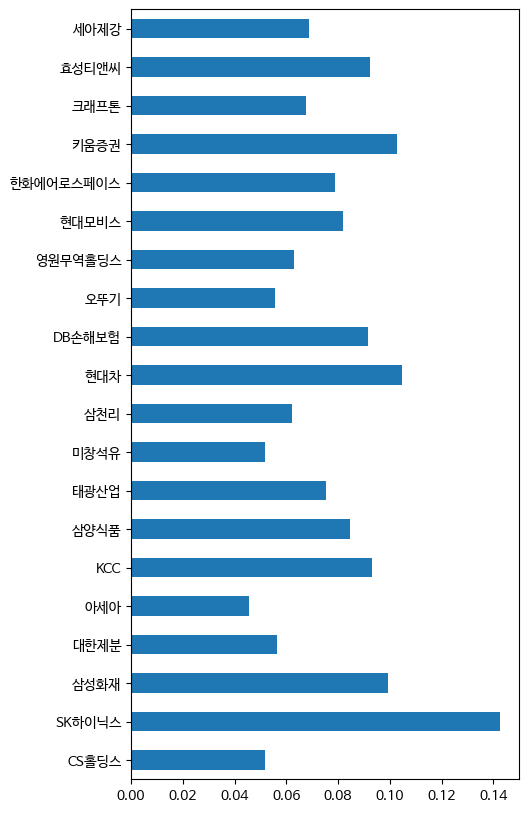

In [87]:
from pypfopt import expected_returns

risk_free_rate= 0.03	#한국무위험지표금리의 1년 평균 사용, https://www.kofr.kr/main.jsp
mu = expected_returns.capm_return(prices.drop("KOSPI", axis=1), market_prices=prices['KOSPI'].to_frame(),
                                  risk_free_rate=risk_free_rate,
                                  frequency=245)	#1년 지정
mu.plot.barh(figsize=(5, 10))

In [88]:
#각 자산간 상관관계
import matplotlib.pyplot as plt
import numpy as np
from pypfopt import risk_models
from pypfopt import plotting

S = risk_models.sample_cov(prices.drop("KOSPI", axis=1), frequency=245)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'CS홀딩스'),
  Text(1, 0, 'SK하이닉스'),
  Text(2, 0, '삼성화재'),
  Text(3, 0, '대한제분'),
  Text(4, 0, '아세아'),
  Text(5, 0, 'KCC'),
  Text(6, 0, '삼양식품'),
  Text(7, 0, '태광산업'),
  Text(8, 0, '미창석유'),
  Text(9, 0, '삼천리'),
  Text(10, 0, '현대차'),
  Text(11, 0, 'DB손해보험'),
  Text(12, 0, '오뚜기'),
  Text(13, 0, '영원무역홀딩스'),
  Text(14, 0, '현대모비스'),
  Text(15, 0, '한화에어로스페이스'),
  Text(16, 0, '키움증권'),
  Text(17, 0, '크래프톤'),
  Text(18, 0, '효성티앤씨'),
  Text(19, 0, '세아제강')])

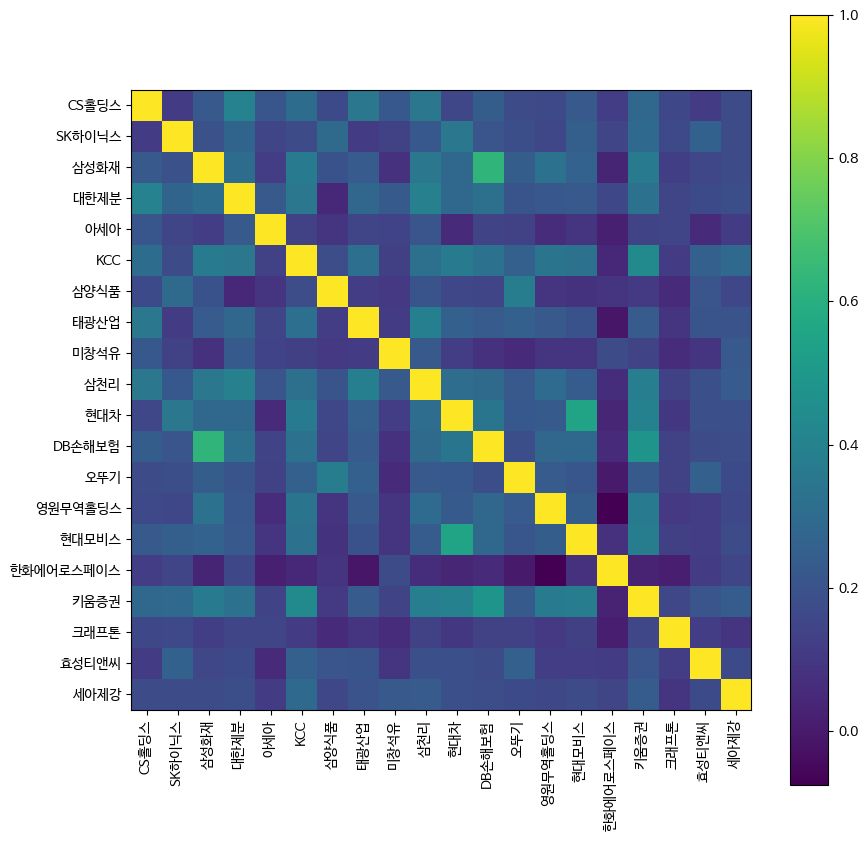

In [89]:
# Plot the correlation matrix
matrix = risk_models.cov_to_corr(S)
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(matrix)
fig.colorbar(cax)
ax.set_xticks(np.arange(0, matrix.shape[0], 1))
ax.set_xticklabels(matrix.index)
ax.set_yticks(np.arange(0, matrix.shape[0], 1))
ax.set_yticklabels(matrix.index)
plt.xticks(rotation=90)

Expected annual return: 8.3%
Annual volatility: 18.3%
Sharpe Ratio: 0.29


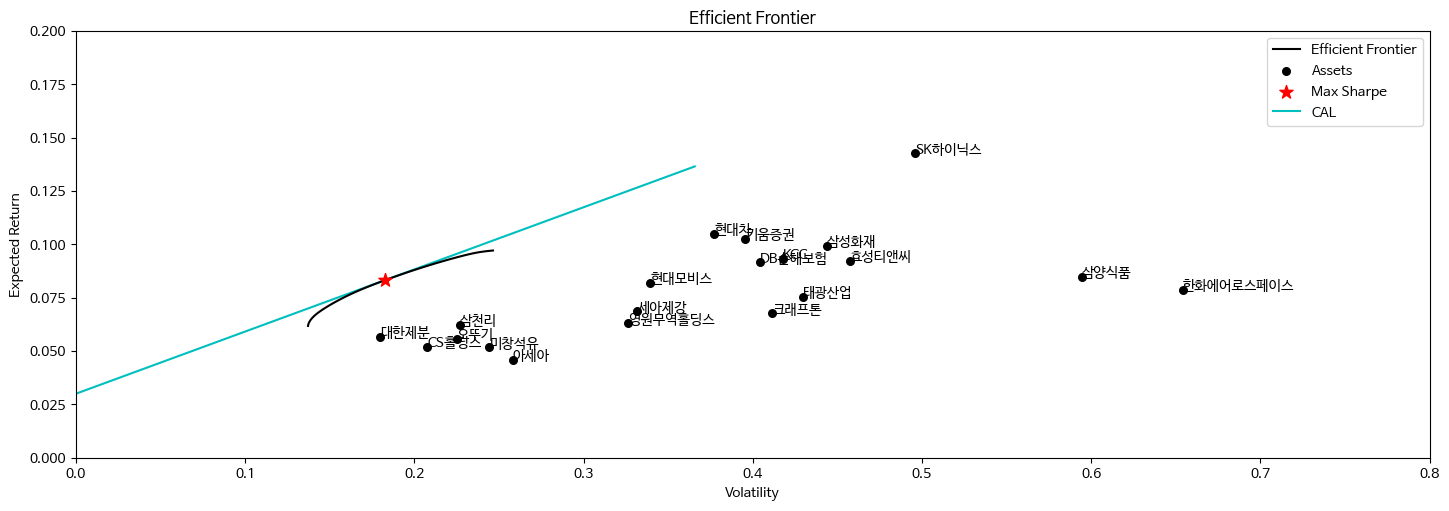

In [91]:
import matplotlib.pyplot as plt
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier

fig, ax = plt.subplots(figsize=(15, 5))
ef = EfficientFrontier(mu, S)

for name in list(ticker_name.values()):
    if name != 'KOSPI' and name != 'KOSDAQ':
        ef.add_constraint(lambda w: w[ef.tickers.index(name)] <= 0.1) # 개별종목 비중 10% 안 넘게

# Plot efficient frontier
plotting.plot_efficient_frontier(ef.deepcopy(), ax=ax, show_tickers=True)
ax.get_lines()[0].set_color("black")
# Plot the tangency portfolio
ef.max_sharpe(risk_free_rate)
weights = ef.clean_weights()
ret_tangent, std_tangent, _ = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)
ax.scatter(std_tangent, ret_tangent, s=100, c="r", marker="*", label="Max Sharpe", zorder=10)
# Plot capital allocation line
ax.plot([0, std_tangent, std_tangent*2], [risk_free_rate, ret_tangent, 2*ret_tangent-risk_free_rate], 'c', label='CAL', zorder=-1)

# Format
ax.set_title("Efficient Frontier")
ax.set_ylabel('Expected Return')
ax.set_xlim(0, 0.8)  #범위 지정
ax.set_ylim(0, 0.2)  #범위 지정
handles, labels = ax.get_legend_handles_labels()
labels[0], labels[1] = ['Efficient Frontier', 'Assets']
ax.legend(handles, labels)
plt.show()

<Axes: xlabel='Weight'>

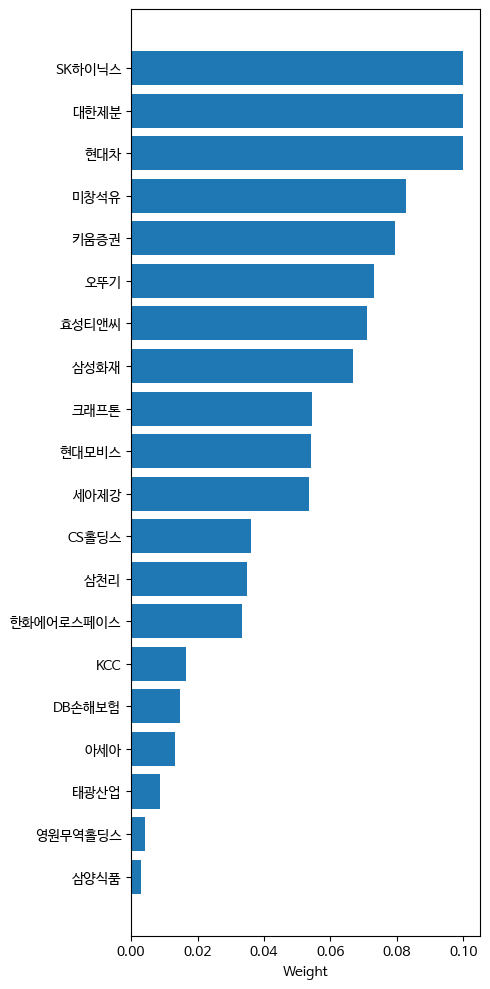

In [92]:
fig, ax = plt.subplots(figsize=(5, 10))
plotting.plot_weights(weights, ax=ax)

In [93]:
weights

OrderedDict([('CS홀딩스', 0.03617),
             ('SK하이닉스', 0.1),
             ('삼성화재', 0.06691),
             ('대한제분', 0.1),
             ('아세아', 0.01323),
             ('KCC', 0.01655),
             ('삼양식품', 0.00293),
             ('태광산업', 0.00884),
             ('미창석유', 0.08268),
             ('삼천리', 0.03477),
             ('현대차', 0.1),
             ('DB손해보험', 0.01472),
             ('오뚜기', 0.07315),
             ('영원무역홀딩스', 0.00414),
             ('현대모비스', 0.05403),
             ('한화에어로스페이스', 0.03344),
             ('키움증권', 0.07952),
             ('크래프톤', 0.0543),
             ('효성티앤씨', 0.07103),
             ('세아제강', 0.0536)])